In [1]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import sklearn.metrics
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re


In [2]:
n_rows = 5000
n_signal_variables = 10
n_noise_variables = 100
n_levels = 500

In [3]:
d = pandas.DataFrame({"y":0.01*numpy.random.normal(size = n_rows)})

In [4]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.uniform(low=-10, high=10, size=1)[0]
    return values

In [5]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [6]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [7]:
d.head()

,y,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,noise_90,noise_91,noise_92,noise_93,noise_94,noise_95,noise_96,noise_97,noise_98,noise_99
0,25.919659,level_155,level_64,level_41,level_62,level_192,level_492,level_395,level_257,level_263,...,level_498,level_373,level_255,level_38,level_281,level_273,level_190,level_205,level_362,level_350
1,19.702852,level_471,level_306,level_455,level_182,level_423,level_301,level_193,level_112,level_153,...,level_351,level_283,level_177,level_130,level_299,level_491,level_237,level_213,level_441,level_438
2,-3.871946,level_83,level_153,level_360,level_41,level_203,level_461,level_346,level_222,level_141,...,level_466,level_375,level_454,level_367,level_352,level_195,level_157,level_11,level_176,level_184
3,3.677739,level_293,level_291,level_80,level_69,level_199,level_272,level_81,level_141,level_265,...,level_382,level_229,level_378,level_106,level_467,level_397,level_48,level_76,level_338,level_151
4,-31.778679,level_305,level_414,level_307,level_200,level_472,level_396,level_447,level_441,level_226,...,level_395,level_480,level_7,level_176,level_213,level_299,level_121,level_18,level_458,level_7


In [8]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [9]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [10]:
plan = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                       'coders':['impact_code']}))
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train_hierarchical = plan.transform(d_train)

In [11]:
p2 = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                     'coders':['impact_code'],
                                                                     'use_hierarchical_estimate':False}))
p2.fit_transform(d_train, y_train)
naive_train_empirical = p2.transform(d_train)

In [12]:
naive_train_empirical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,12.975690,10.640005,-1.833454,1.513399,9.446562,-1.524784,8.944268,14.830627,11.095615,-12.134576,...,-0.411263,-0.904514,9.307610,6.169871,4.320603,-1.023742,6.393530,7.054961,-2.522800,2.129427
1,11.466253,28.091301,6.169668,9.742786,2.778689,6.522990,0.238828,6.245041,7.135629,-7.899229,...,11.362633,-1.201903,5.283764,8.000261,-8.215772,-2.099162,13.408643,11.829987,-3.424646,16.076257
2,-2.964461,-4.835130,-5.032614,2.196913,-6.356930,6.969021,-4.568765,6.145916,14.180327,-6.167832,...,-2.475742,-6.179381,-3.664086,1.386708,-12.733849,3.096199,7.139400,-0.197928,-11.313236,-4.874125
3,-5.274442,4.473094,-2.538220,0.461463,7.057292,4.231419,-7.258432,6.265068,13.748314,-2.028406,...,-3.022754,-5.484807,2.484513,-0.976276,3.791397,1.805232,4.300116,5.015738,-7.092414,-5.084980
4,7.311978,-5.293393,-2.887305,-14.247425,8.258109,16.165871,13.104958,6.058655,-0.661502,1.094148,...,-0.012065,-0.673847,10.400882,-5.868442,0.861038,4.094395,7.139400,-4.354323,9.548240,6.245860


In [13]:
naive_train_hierarchical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,5.898777,6.422748,-1.404740,0.700391,6.123110,-0.862426,4.013819,12.718363,2.483273,-6.080292,...,-0.256353,-0.187136,2.562087,2.763993,0.656579,-0.598023,0.642683,4.929764,-1.512586,1.342797
1,6.686678,12.693100,3.604390,3.525175,2.225002,4.411496,0.070832,3.919399,6.425468,-6.296892,...,7.513672,-0.803121,3.163786,5.706859,-4.505718,-0.368754,12.427668,6.499562,-1.914274,10.566417
2,-1.522285,-4.797304,-3.170749,1.432374,-4.161974,6.002695,-3.591532,4.900227,7.189916,-2.403197,...,-1.661316,-2.474286,-1.314258,1.222777,-10.191499,2.918407,4.241058,-0.168936,-9.485919,-1.953286
3,-4.799495,1.539483,-1.460504,0.407137,5.607358,3.626413,-5.129056,5.850257,9.401817,-0.931346,...,-2.421663,-3.614740,1.767594,-0.689094,2.672643,1.274012,2.602179,3.913185,-4.548500,-3.347958
4,3.773199,-2.638254,-0.936196,-8.018498,5.150493,13.840739,10.388445,3.753786,-0.427940,0.595625,...,-0.007140,-0.424618,8.821594,-3.452903,0.556872,1.961436,4.241058,-2.931664,6.166423,3.638228


In [14]:
cross_frame.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-0.903907,2.409819e+00,-2.206035,-1.216076,3.833532,-7.374032,2.416499,12.183417,0.000000,-10.531036,...,-1.838599,0.000000,0.000000,1.344418,-0.707952,4.306736,0.000000e+00,3.593457,-3.554743,6.854685
1,5.592190,-2.775558e-17,1.518906,0.000000,-0.419968,2.552386,0.000000,0.000000,5.305591,-7.125765,...,7.820069,-0.536692,0.367978,4.634549,-14.473906,-1.468164,1.237282e+01,2.874574,-12.575399,7.987548
2,1.056733,-4.904497e+00,-2.518852,2.170581,-4.913636,5.475924,-5.533760,7.832567,0.000000,-2.072597,...,-1.267959,-2.507439,-0.928762,0.000000,-9.026550,4.917768,1.830114e+00,-0.421515,-10.324361,1.053975
3,-7.175735,1.082064e+00,0.001182,3.684899,5.762007,2.765327,-6.815170,6.135630,9.909871,-1.084417,...,-3.758846,-8.666145,1.379108,-1.275523,2.262215,5.032005,6.938894e-18,3.947249,0.000000,-2.050624
4,4.191552,5.551115e-17,-2.768618,-8.790173,1.544238,0.000000,8.163005,-0.250125,-6.001150,-2.804514,...,-4.448891,-6.313433,7.093330,-5.166885,-2.273141,0.650811,1.830114e+00,-7.175866,3.891076,0.000000


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_empirical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_empirical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["naive_train_hierarchical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_hierarchical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_empirical_correlation,naive_train_hierarchical_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.519201,0.493613,0.132750,0.182707,False
1,var_1_impact_code,0.530619,0.506109,0.153268,0.183085,False
2,var_2_impact_code,0.535225,0.512776,0.196658,0.165878,False
3,var_3_impact_code,0.517356,0.487151,0.127861,0.172715,False
4,var_4_impact_code,0.540441,0.510994,0.188235,0.137250,False
5,var_5_impact_code,0.526333,0.498497,0.161512,0.146269,False
6,var_6_impact_code,0.554781,0.531180,0.230045,0.205744,False
7,var_7_impact_code,0.531274,0.504525,0.160129,0.153691,False
8,var_8_impact_code,0.531246,0.498771,0.137829,0.102678,False
9,var_9_impact_code,0.524514,0.501964,0.144959,0.156282,False


(0.7944942472682046, 3.8656423359267064e-25)


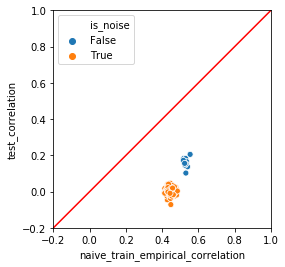

In [16]:
print(scipy.stats.pearsonr(corr_frame['naive_train_empirical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_empirical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8050861462543191, 3.010629592261873e-26)


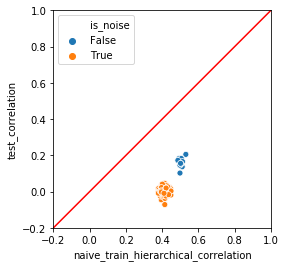

In [17]:
print(scipy.stats.pearsonr(corr_frame['naive_train_hierarchical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_hierarchical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.7698141640862998, 8.619883732721771e-23)


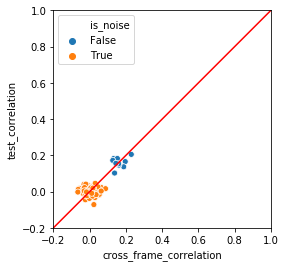

In [18]:
print(scipy.stats.pearsonr(corr_frame['cross_frame_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [19]:
plan.score_frame_.tail()

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
105,noise_95_impact_code,noise_95,impact_code,True,True,0.022577,0.261046,110.0,False
106,noise_96_impact_code,noise_96,impact_code,True,True,-0.029680,0.139502,110.0,False
107,noise_97_impact_code,noise_97,impact_code,True,True,0.018164,0.365900,110.0,False
108,noise_98_impact_code,noise_98,impact_code,True,True,-0.017243,0.390700,110.0,False
109,noise_99_impact_code,noise_99,impact_code,True,True,0.011815,0.556461,110.0,False


In [20]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code',
 'var_1_impact_code',
 'var_2_impact_code',
 'var_3_impact_code',
 'var_4_impact_code',
 'var_5_impact_code',
 'var_6_impact_code',
 'var_7_impact_code',
 'var_8_impact_code',
 'var_9_impact_code',
 'noise_10_impact_code',
 'noise_19_impact_code',
 'noise_38_impact_code',
 'noise_47_impact_code',
 'noise_55_impact_code',
 'noise_83_impact_code']

In [21]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [22]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [23]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [24]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [25]:
fitter.fit(naive_train_empirical[all_vars], y_train)
plot_train["predict_naive_empirical_all_vars"] = fitter.predict(naive_train_empirical[all_vars])
plot_test["predict_naive_empirical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [26]:
fitter.fit(naive_train_hierarchical[all_vars], y_train)
plot_train["predict_naive_hierarchical_all_vars"] = fitter.predict(naive_train_hierarchical[all_vars])
plot_test["predict_naive_hierarchical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [27]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_empirical_all_vars,predict_naive_hierarchical_all_vars
0,-31.778679,-18.977370,-21.283131,-3.930635,-6.242831
1,-4.555266,-15.864892,-15.678299,-2.310098,-4.437963
2,-34.713542,-7.728829,-7.683773,0.544357,1.598403
3,16.261945,2.249430,0.293210,-0.277120,0.001385
4,3.566648,12.984392,18.154610,3.418162,6.761349


In [28]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

3.2894834694561514


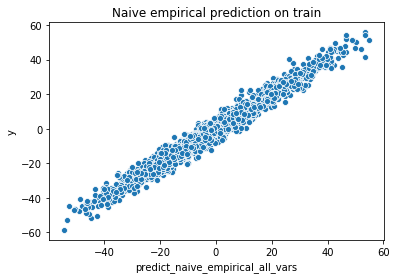

In [29]:
print(rmse(plot_train["predict_naive_empirical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive empirical prediction on train")

4.818047656494819


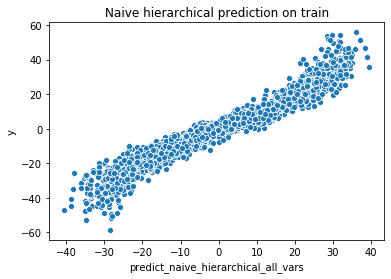

In [30]:
print(rmse(plot_train["predict_naive_hierarchical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on train")

15.13978338696106


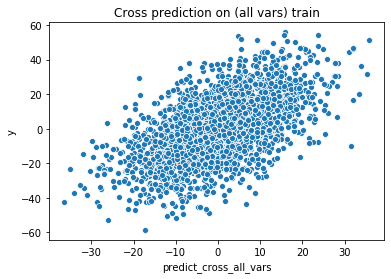

In [31]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

15.584841247170413


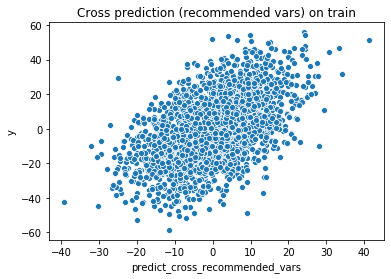

In [32]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

17.78736144240012


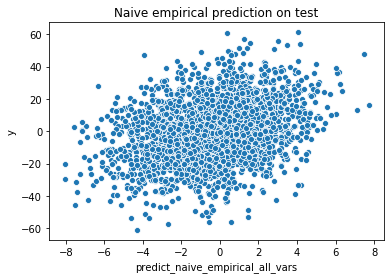

In [33]:
print(rmse(plot_test["predict_naive_empirical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive empirical prediction on test")

17.437505009687044


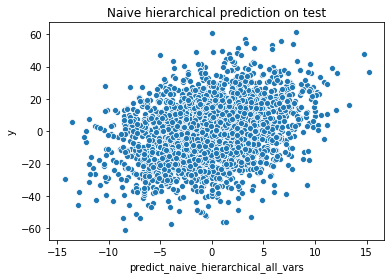

In [34]:
print(rmse(plot_test["predict_naive_hierarchical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on test")

16.33858931776184


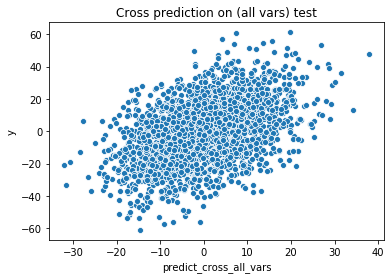

In [35]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

15.918395829300582


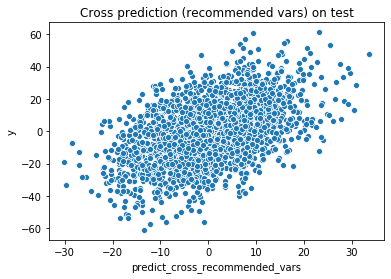

In [36]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [37]:
smf1 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train_empirical[all_vars])).fit()
smf1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     659.7
Date:                Thu, 01 Aug 2019   Prob (F-statistic):               0.00
Time:                        17:11:00   Log-Likelihood:                -6472.0
No. Observations:                2480   AIC:                         1.317e+04
Df Residuals:                    2369   BIC:                         1.381e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1125      0.068     -1.664      0.096      -0.245       0.020
var_0_impact_code        0.0620      0.008      7.382      0.000       0.046       0.078
var_1_impact_code        0.0622      0.008      7.551      0.000       0.046       0.078
var_2_impact_code        0.0736      0.008      8.959      0.000       0.057       0.090
var_3_impact_code        0.0654      0.008      7.788      0.000       0.049       0.082
var_4_impact_code        0.0610      0.008      7.452      0.000       0.045       0.077
var_5_impact_code        0.0672      0.008      8.132      0.000       0.051       0.083
var_6_impact_code        0.0729      0.008      9.104      0.000       0.057       0.089
var_7_impact_code        0.0664      0.008      8.029      0.000       0.050       0.083
var_8_impact_code        0.0611      0.008      7.396      0.000       0.045       0.077
var_9_impact_code        0.0552      0.008      6.588      0.000       0.039       0.072
noise_0_impact_code      0.0456      0.009      4.975      0.000       0.028       0.064
noise_1_impact_code      0.0349      0.009      3.704      0.000       0.016       0.053
noise_2_impact_code      0.0211      0.010      2.203      0.028       0.002       0.040
noise_3_impact_code      0.0292      0.010      3.007      0.003       0.010       0.048
noise_4_impact_code      0.0408      0.009      4.489      0.000       0.023       0.059
noise_5_impact_code      0.0466      0.009      5.094      0.000       0.029       0.065
noise_6_impact_code      0.0383      0.009      4.068      0.000       0.020       0.057
noise_7_impact_code      0.0463      0.009      5.082      0.000       0.028       0.064
noise_8_impact_code      0.0373      0.009      3.979      0.000       0.019       0.056
noise_9_impact_code      0.0476      0.009      5.123      0.000       0.029       0.066
noise_10_impact_code     0.0539      0.009      6.086      0.000       0.037       0.071
noise_11_impact_code     0.0366      0.009      3.980      0.000       0.019       0.055
noise_12_impact_code     0.0276      0.010      2.863      0.004       0.009       0.047
noise_13_impact_code     0.0310      0.009      3.473      0.001       0.014       0.049
noise_14_impact_code     0.0457      0.009      4.992      0.000       0.028       0.064
noise_15_impact_code     0.0573      0.010      5.940      0.000       0.038       0.076
noise_16_impact_code     0.0527      0.009      5.731      0.000       0.035       0.071
noise_17_impact_code     0.0320      0.009      3.432      0.001       0.014       0.050
noise_18_impact_code     0.0445      0.009      4.790      0.000       0.026       0.063
noise_19_impact_code     0.0567      0.009      6.423      0.000       0.039       0.074
noise_20_impact_code     0.0230      0.009      2.472    

In [38]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_naive_empirical_all_vars"])

0.9683884297299028

In [39]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_naive_empirical_all_vars"])

0.06282228960826708

In [40]:
smf2 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     10.63
Date:                Thu, 01 Aug 2019   Prob (F-statistic):          8.09e-138
Time:                        17:11:01   Log-Likelihood:                -10258.
No. Observations:                2480   AIC:                         2.074e+04
Df Residuals:                    2369   BIC:                         2.138e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3051      0.321      0.950      0.342      -0.325       0.935
var_0_impact_code        0.2978      0.048      6.166      0.000       0.203       0.393
var_1_impact_code        0.3904      0.046      8.515      0.000       0.300       0.480
var_2_impact_code        0.5068      0.046     11.135      0.000       0.418       0.596
var_3_impact_code        0.3538      0.048      7.389      0.000       0.260       0.448
var_4_impact_code        0.4724      0.046     10.354      0.000       0.383       0.562
var_5_impact_code        0.4617      0.050      9.299      0.000       0.364       0.559
var_6_impact_code        0.5773      0.046     12.641      0.000       0.488       0.667
var_7_impact_code        0.4438      0.046      9.564      0.000       0.353       0.535
var_8_impact_code        0.3780      0.047      8.120      0.000       0.287       0.469
var_9_impact_code        0.3757      0.048      7.886      0.000       0.282       0.469
noise_0_impact_code      0.0486      0.058      0.839      0.402      -0.065       0.162
noise_1_impact_code     -0.0771      0.055     -1.396      0.163      -0.185       0.031
noise_2_impact_code      0.0221      0.057      0.386      0.700      -0.090       0.135
noise_3_impact_code     -0.0923      0.062     -1.480      0.139      -0.214       0.030
noise_4_impact_code      0.0005      0.057      0.009      0.993      -0.111       0.112
noise_5_impact_code      0.0293      0.054      0.541      0.588      -0.077       0.135
noise_6_impact_code      0.0272      0.057      0.474      0.636      -0.085       0.140
noise_7_impact_code     -0.0273      0.055     -0.502      0.616      -0.134       0.080
noise_8_impact_code     -0.1167      0.057     -2.056      0.040      -0.228      -0.005
noise_9_impact_code     -0.0306      0.056     -0.543      0.587      -0.141       0.080
noise_10_impact_code     0.1335      0.051      2.619      0.009       0.034       0.234
noise_11_impact_code     0.0386      0.054      0.719      0.472      -0.067       0.144
noise_12_impact_code    -0.0572      0.057     -0.995      0.320      -0.170       0.055
noise_13_impact_code     0.0439      0.053      0.823      0.411      -0.061       0.149
noise_14_impact_code     0.0356      0.059      0.607      0.544      -0.080       0.151
noise_15_impact_code     0.0262      0.061      0.426      0.670      -0.094       0.147
noise_16_impact_code     0.1282      0.058      2.192      0.028       0.013       0.243
noise_17_impact_code     0.0218      0.058      0.378      0.706      -0.091       0.135
noise_18_impact_code    -0.0634      0.056     -1.137      0.256      -0.173       0.046
noise_19_impact_code     0.1454      0.052      2.777      0.006       0.043       0.248
noise_20_impact_code     0.0135      0.057      0.238    

In [41]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_all_vars"])

0.33037759563746194

In [42]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_all_vars"])

0.20927038630303385

In [43]:
smf3 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[recommended_vars])).fit()
smf3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     63.01
Date:                Thu, 01 Aug 2019   Prob (F-statistic):          4.88e-170
Time:                        17:11:01   Log-Likelihood:                -10330.
No. Observations:                2480   AIC:                         2.069e+04
Df Residuals:                    2463   BIC:                         2.079e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.4800      0.316      1.520      0.129      -0.139       1.099
var_0_impact_code        0.3134      0.048      6.590      0.000       0.220       0.407
var_1_impact_code        0.3813      0.045      8.388      0.000       0.292       0.470
var_2_impact_code        0.5176      0.045     11.458      0.000       0.429       0.606
var_3_impact_code        0.3612      0.047      7.643      0.000       0.269       0.454
var_4_impact_code        0.4913      0.045     10.903      0.000       0.403       0.580
var_5_impact_code        0.4736      0.049      9.624      0.000       0.377       0.570
var_6_impact_code        0.5900      0.045     13.066      0.000       0.501       0.679
var_7_impact_code        0.4582      0.046      9.950      0.000       0.368       0.548
var_8_impact_code        0.3520      0.046      7.652      0.000       0.262       0.442
var_9_impact_code        0.4121      0.047      8.785      0.000       0.320       0.504
noise_10_impact_code     0.1350      0.050      2.683      0.007       0.036       0.234
noise_19_impact_code     0.1317      0.052      2.539      0.011       0.030       0.233
noise_38_impact_code     0.1118      0.055      2.028      0.043       0.004       0.220
noise_47_impact_code     0.2378      0.053      4.519      0.000       0.135       0.341
noise_55_impact_code     0.1194      0.052      2.280      0.023       0.017       0.222
noise_83_impact_code     0.1562      0.050      3.098      0.002       0.057       0.255
==============================================================================
Omnibus:                        0.016   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.992   Jarque-Bera (JB):                0.038
Skew:                           0.001   Prob(JB):                        0.981
Kurtosis:                       2.981   Cond. No.                         7.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_recommended_vars"])

0.29042971769795434

In [45]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_recommended_vars"])

0.2494191321058592